**Setup and Training:**

This notebook will prepare and train a machine learning model (will use SVM and random forests) to predict the arousal of sound sample. We will be making use of the pyAudioAnalysis library.

We will be making the assumption of working out of the ./content folder.



In [ ]:
# First, install all of the dependencies
!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub
!pip list | grep -E "pyAudio|eyed3|pydub"
!pwd
!ls

     |████████████████████████████████| 41.3 MB 2.0 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=b8ac1dfd7aa89fd5515039932f8a7056d8da6cad5c741e1903b9652052c2cf89
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis
     |████████████████████████████████| 245 kB 5.2 MB/s 
     |████████████████████████████████| 242 kB 50.6 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incomp

In [ ]:
import os

# First, we need to process the data. We will need to convert videos to audio.
# We will assume a filetree structure as follows:
# - ./content
# - - - requirements.txt
# - - - sample_data
# - - - audiodata
# - - - - - arousal.csv
# - - - - - audio.wav
# - - - models
# - - - - - audio_predict_model

!mkdir -p audiodata
!mkdir -p models
!pwd
!ls


In [ ]:
# First, we want to grab all of the video files from enterfaceinto preprocess and convert it.
# Note, if we are loading the data from the zip, SKIP THIS CELL and run the next
# Note that the variable 'database' is where the enterface database is located
# and we assume it is inside a google drive.
def get_from_enterface(emos):
    database = "/content/drive/MyDrive/CMPT419/'enterface database'"
    stream = os.popen(f"ls {database}")
    # retrieve the subjects filetree structure as a string, and place the name of each folder into a list
    folders = stream.read().split("\n")[0:-1]

    # loop through each subject_n folder and grab the anger folder
    for i, folder in enumerate(folders):
        # loop through emotions ["anger", "sadness", ...]
        for emo in emos:
            # get the path of the emotion, and get the sentence folder directory e.g., anger/'sentence 1'
            path = f"{database}/'{folder}'/{emo}"
            stream = os.popen(f"ls {path}")
            sentence_folders = stream.read().split("\n")[0:-1]
            # loop through folders sentence 1, 2, 3, ...
            sentence_cap = len(sentence_folders)
            for j in range(0, sentence_cap):
                # copy the .avi files into the dump folder
                vid_path = f"{path}/'{sentence_folders[j]}'"
                os.system(f"find {vid_path} \*.avi -exec cp {{}} ./ \;")

emotions = ["anger", "disgust", "fear", "happiness", "sadness", "surprise"]
get_from_enterface(emotions)

print(f"Done.")


In [ ]:
# if we have previously saved the data, then we should unzip it.
# place a COPY of the audiowav.zip into the audiodata folder
# if running this cell, skip to the cell where we import pandas.
!cp "/content/drive/MyDrive/CMPT419/audiowav.zip" "./audiodata/"
!unzip -q "/content/audiodata/audiowav.zip"
!rm "/content/audiodata/audiowav.zip"
!mv  "./eNTERFACE05_audio"/* "./audiodata/"
!rm -r ./eNTERFACE05_audio
!pwd
!ls

In [ ]:
# If we're processing the raw data, then we need to convert the video into wav
# remove the extraneous thumbs.db file
!rm -f Thumbs.db

# using ffmpeg, convert the video.avi into audio.wav files
!for i in *.avi; do ffmpeg -loglevel panic -i "$i" -vn -acodec copy "${i%.*}.wav"; mv "${i%.*}.wav" "./audiodata/${i%.*}.wav"; rm "${i%.*}.avi"; done

# check the directory now
!pwd
!ls

In [ ]:
# We may want to save the audio.wav files so we won't have to spend so much time processing it next.
!zip -r -q audiowav.zip audiodata
!pwd
!ls

In [ ]:
# If we are using manual annotation, skip this cell and run the import for pyAudioAnalysis import
# This line basically generates an empty csv file which can be used to store
# annotated values. 

# Now, we need a csv file with annotations for each audio.wav file. Let's make one.
import pandas as pd
import numpy as np

FILENAME = "arousal"

def generate_csv_annotation(FILENAME):
  folder = f"./audiodata"
  stream = os.popen(f"ls {folder}")
  cols = np.array(stream.read().split('\n')[0:-1])
  dframe = pd.DataFrame(cols)
  dframe.to_csv(f"{folder}/{FILENAME}", header=False, index=False)

generate_csv_annotation(FILENAME)
print(f"Done. Check {FILENAME}. Note - this is EMPTY and needs annotation!")
  

In [ ]:
# Before running this section, please make sure ANNOTATED_FILE.csv is inside the audiodata folder!
# We will now start training the model.

from pyAudioAnalysis import audioTrainTest as ATT

# Parameters can be found in https://github.com/tyiannak/pyAudioAnalysis/blob/master/pyAudioAnalysis/audioTrainTest.py L. 368.
wavfilesdir = "./audiodata/"
p_mid_window = 1
p_mid_step = 1
p_short_window = ATT.shortTermWindow
p_short_step = ATT.shortTermStep
p_model_type = "svm"
p_model_name = "AudioPredictModelSVM"

# this function does not return anything, instead, it saves the model after training it.
print(f"Training the model. This may take a while.\n")
ATT.feature_extraction_train_regression(wavfilesdir, p_mid_window, p_mid_step, p_short_window, 
                                        p_short_step, p_model_type, p_model_name)

# NOTE: The docs mention (a) the WAV filenames - without extension, but this appears to be FALSE
# In the screenshot directly beneath, the .wav extension was included. IN ADDITION,
# the script failed when it the .wav extension was NOT INCLUDED in the csv!

print(f"Done training models.")

# move the model to the models folder
!mv AudioPredictModel_annotate_with_means ./models
!mv AudioPredictModel_annote_with_meansMEANS ./models
!mv AudioPredictModel_annotate_with_med ./models
!mv AudioPredictModel_annote_with_medMEANS ./models

print("Finished moving objects into folder.")

In [ ]:
# if desired, zip up the models
!zip -r -q audiomodels.zip models
!pwd
!ls

# Testing and Validation

This section is for testing our model. Since each model takes about ~5-6 hour to train, doing a 5-fold cross-validation will be too time-costly. Therefore, what we will do is an 80-20 random split as a compromise.

The infrastructure is set up to train regression of all audio files inside a folder, along with a csv file which provides the ground truths. Two things must happen:

First, we must read in a list of all the audio files in the target directory, and randomly select 20% of it, and move it to a different folder.

We must then generate a new dataframe after removing those 20% of rows, and save that csv.

Training will then be done on the 80% of the remaining data. After the model is done, we will test the 20% test data.

In [ ]:
# Set up the main folder for the audio data if it is not already.
!mkdir -p audiodata
!mkdir -p testaudiodata
!mkdir -p models
!pwd
!ls

/content
audiodata  drive  models  sample_data  testaudiodata


In [ ]:
# create a folder to store the csv files for comparing results
!mkdir /content/testgroundtruth/

In [ ]:
# If not done already, please upload the ground truth csv into the audiodata
# folder. We will grab the audio into the audiodata folder
# (if we haven't done this already) 
!cp "/content/drive/MyDrive/CMPT419/audiowav.zip" "./audiodata/"
!unzip -q "/content/audiodata/audiowav.zip"
!rm "/content/audiodata/audiowav.zip"
!mv  "./eNTERFACE05_audio"/* "./audiodata/"
!rm -r ./eNTERFACE05_audio
!pwd
!ls


/content
audiodata  drive  models  sample_data  testaudiodata  testgroundtruth


In [ ]:
# import pandas if not already
import pandas as pd
import os
import shutil

# THIS SECTION WILL FAIL IF THE CSV FILES FOR GROUND TRUTH IS NOT UPLOADED
# TO THE audiodata FOLDER

# we will assume that the mean_csv and med_csv is sorted so that the rows are
# isomorphic. therefore, operations on one will be reflected on the other.
# This will depend on the csv annotation processing script.

csv_mean_path = "/content/audiodata/annotate_with_means.csv"
csv_med_path = "/content/audiodata/annotate_with_med.csv"
csv_mean_file = pd.read_csv(csv_mean_path, header=None)
csv_med_file = pd.read_csv(csv_med_path, header=None)

# grab the 20% (returned as row index) of data for testing
train_test_df = csv_mean_file.copy(deep=True)
test_set = train_test_df.sample(frac=0.2).index

# set up the test set
mean_test = csv_mean_file.iloc[test_set]
med_test = csv_med_file.iloc[test_set]

# remove the test set from the train set
mean_train = csv_mean_file.drop(test_set)
med_train = csv_med_file.drop(test_set)

# save this new csv file used for training 80% of the data
mean_train.to_csv("/content/audiodata/annotate_with_means80.csv", header=False, index=False)
med_train.to_csv("/content/audiodata/annotate_with_med80.csv", header=False, index=False)

mean_test.to_csv("/content/testaudiodata/annotate_with_means20.csv", header=False, index=False)
med_test.to_csv("/content/testaudiodata/annotate_with_med20.csv", header=False, index=False)

# print out what the dataframes will look like
print(f"The following data will be used to train:")
print(mean_train)
print(f"The following data will be used to test:")
print(mean_test)

# now we have to move the physical audio files to the other audio folder
files_to_move = mean_test[mean_test.columns[0]].tolist()
print(f"We will be moving the files\n{files_to_move}")

base_path = "/content/audiodata/"
destination = "/content/testaudiodata/"
for file_to_move in files_to_move:
  subject = base_path+file_to_move
  os.system(f"mv {subject} {destination}")

# remove the full csv files so the model doesn't actually train this
os.system(f"rm {base_path}/annotate_with_means.csv")
os.system(f"rm {base_path}/annotate_with_med.csv")

The following data will be used to train:
                 0    1
0     s10_an_1.wav  0.3
1     s10_an_2.wav  0.3
2     s10_an_3.wav  0.3
3     s10_an_4.wav  0.3
4     s10_an_5.wav  0.1
...            ...  ...
1250   s9_sa_4.wav -1.0
1253   s9_su_2.wav -0.4
1254   s9_su_3.wav -0.3
1255   s9_su_4.wav -0.4
1256   s9_su_5.wav -0.2

[1006 rows x 2 columns]
The following data will be used to test:
                 0    1
709   s32_sa_3.wav -0.5
134   s15_fe_5.wav -0.2
1065  s43_ha_4.wav -0.4
368   s22_di_4.wav -0.6
837   s37_an_1.wav -0.1
...            ...  ...
728   s33_fe_2.wav -0.4
937    s3_fe_1.wav  0.2
1132   s4_su_1.wav  0.1
629   s30_an_3.wav -0.4
512   s27_di_1.wav -0.5

[251 rows x 2 columns]
We will be moving the files
['s32_sa_3.wav', 's15_fe_5.wav', 's43_ha_4.wav', 's22_di_4.wav', 's37_an_1.wav', 's37_su_2.wav', 's23_su_4.wav', 's43_di_3.wav', 's34_su_2.wav', 's27_fe_5.wav', 's14_an_3.wav', 's35_sa_5.wav', 's17_an_1.wav', 's42_su_4.wav', 's24_di_3.wav', 's5_su_5.wav', 's17_di_

0

In [ ]:
# There are times when we want to move the audio based on existing trained file.
# If we already have things set up from before, run this cell instead of the one above
# Change the name of the csv file for different models. (User-defined)
import pandas as pd
import os

split_file20_path = "/content/testgroundtruth/annotate_with_means20.csv"
split_file20 = pd.read_csv(split_file20_path, header=None)
data_path = "/content/audiodata/"
test_path = "/content/testaudiodata/"
audiofile_names = split_file20[0].tolist()

for audiofile_name in audiofile_names:
  os.system(f"mv {data_path}{audiofile_name} {test_path}{audiofile_name}")

print(f"Done.")

Done.


In [ ]:
# finally, train the model...

from pyAudioAnalysis import audioTrainTest as ATT

# Parameters can be found in https://github.com/tyiannak/pyAudioAnalysis/blob/master/pyAudioAnalysis/audioTrainTest.py L. 368.
wavfilesdir = "/content/audiodata/"
p_mid_window = 1
p_mid_step = 1
p_short_window = ATT.shortTermWindow
p_short_step = ATT.shortTermStep
p_model_type = "randomforest"
p_model_name = "AudioPredictModel80"

# this function does not return anything, instead, it saves the model after training it.
print(f"Training the model. This may take a while.\n")
ATT.feature_extraction_train_regression(wavfilesdir, p_mid_window, p_mid_step, p_short_window, 
                                        p_short_step, p_model_type, p_model_name)

In [ ]:
# move the csv files
!mv /content/testaudiodata/*.csv /content/testgroundtruth/ 

In [ ]:
# move model to the models folder, and the alternate folder.
!mv ./AudioPredictModel80_annotate_with_means80 /content/models
!mv ./AudioPredictModel80_annotate_with_means80MEANS /content/models
!mv ./AudioPredictModel80_annotate_with_med80 /content/testgroundtruth
!mv ./AudioPredictModel80_annotate_with_med80MEANS /content/testgroundtruth

In [ ]:
# Here, some utility statistical tests are provided.
import numpy as np

def calc_RMSE(predicted, actual):
  actual = np.array(actual)
  predicted = np.array(predicted)
  count = len(predicted) # same as len(actual)

  SSE = np.sum((actual-results)**2)
  RMSE = np.sqrt(SSE/count)

  return RMSE

In [ ]:
# now, we have to test the model.
from pyAudioAnalysis import audioTrainTest as ATT

# depending on which model is inside the models folder, change the paramter below
model_choice = ["means", "med"]
choice = 0
choice_activated = model_choice[choice] # change between 0 and 1

# First, locate the folder where the model exists.
# Note that the Audio_Train notebook saves the model as AudioPredictModel.
# the _csvfile suffix is to be ignored. If we have multiple models, we may want
# to move one temporarily to another folder...
model_path = f"{os.getcwd()}/models/AudioPredictModel80"

# we will assume that there is an audiotest folder, which stores the audio to
# be tested.

test_path = f"{os.getcwd()}/testaudiodata/" # testaudiodata to test with the 20 unknown

# we retrieve a list of audio files in the test folder
stream = os.popen(f"ls {test_path}")
audio_names = stream.read().split('\n')[0:-1] # [0:-1] since default has an empty element, [1:-1] if /models/ in audiotest
model_type = "randomforest" # other option is knn or svm - check docs
# https://github.com/tyiannak/pyAudioAnalysis/blob/master/pyAudioAnalysis/audioTrainTest.py L. 368.

results = []

for i, audio_name in enumerate(audio_names):
  res = ATT.file_regression(test_path+audio_name, model_path, model_type)
  results.append(res[0][0])

# we now show the results
predicted = [z for z in zip(audio_names, results)]
print(f"predicted {len(predicted)} elements.")
print(results)

# read in the ground truths
mid_truths_path = f"/content/testgroundtruth/annotate_with_{choice_activated}20SVM.csv"
mid_truths = pd.read_csv(mid_truths_path, header=None)
ymid = mid_truths[mid_truths.columns[1]].tolist()

print(f"Ground truth {len(ymid)} elements.")
print(ymid)

# calculate the RMSE score comparing to ground truth
score = calc_RMSE(results, ymid)
print(f"The RMSE score is {score} for {model_choice[choice]}")

predicted 251 elements.
[0.03000000000000004, -0.5280000000000006, 0.045, 0.25499999999999984, 0.08199999999999999, 0.3289999999999999, -0.696, -0.6300000000000007, -0.5330000000000003, -0.5180000000000006, -0.5160000000000005, -0.2849999999999997, -0.473, -0.16999999999999982, -0.37599999999999995, -0.5479999999999999, -0.6470000000000007, -0.4710000000000004, -0.5100000000000005, -0.40099999999999947, -0.134, -0.5450000000000006, -0.7299999999999993, -0.3579999999999997, -0.14700000000000002, -0.6390000000000001, -0.06099999999999988, -0.12599999999999986, -0.14799999999999996, 0.057, -0.04199999999999997, -0.021999999999999978, 0.08800000000000002, 0.32800000000000046, -0.43200000000000005, -0.3370000000000002, -0.24399999999999966, -0.5530000000000005, -0.48899999999999977, -0.32000000000000034, -0.5189999999999998, 0.21300000000000005, 0.07099999999999988, -0.41400000000000003, -0.030000000000000027, 0.10699999999999983, -0.6090000000000008, -0.4040000000000001, -0.490999999999999

In [ ]:
# if we want to rerun the code cell above with median model, change the mean_truths_path name
# we'll also swap the models out here
!mv /content/models/AudioPredictModel80SVM_annotate_with_means80SVM /content/testgroundtruth/
!mv /content/models/AudioPredictModel80SVM_annotate_with_means80SVMMEANS /content/testgroundtruth/
!mv /content/testgroundtruth/AudioPredictModel80SVM_annotate_with_med80SVM /content/models/
!mv /content/testgroundtruth/AudioPredictModel80SVM_annotate_with_med80SVMMEANS /content/models/

In [ ]:
# if we want to swap them back again (testing with means), run this...
!mv /content/models/AudioPredictModel80SVM_annotate_with_med80SVM /content/testgroundtruth/
!mv /content/models/AudioPredictModel80SVM_annotate_with_med80SVMMEANS /content/testgroundtruth/
!mv /content/testgroundtruth/AudioPredictModel80SVM_annotate_with_means80SVM /content/models/
!mv /content/testgroundtruth/AudioPredictModel80SVM_annotate_with_means80SVMMEANS /content/models/

mv: cannot stat '/content/models/AudioPredictModel80SVM_annotate_with_med80SVM': No such file or directory
mv: cannot stat '/content/models/AudioPredictModel80SVM_annotate_with_med80SVMMEANS': No such file or directory
mv: cannot stat '/content/testgroundtruth/AudioPredictModel80SVM_annotate_with_means80SVM': No such file or directory
mv: cannot stat '/content/testgroundtruth/AudioPredictModel80SVM_annotate_with_means80SVMMEANS': No such file or directory


# Visualization

This section is for visualizing the results. We want to see, in addition to the
RMSE, what the individual errors are. Therefore, we map a scatterplot.
Furthermore, we want to see how the data distributes, so we present it
in a histogram.

In [ ]:
# If we're plotting some results, let's import matplotlib.
import matplotlib.pyplot as pplt

Text(0.5, 1.0, 'Absolute error of SVM test data')

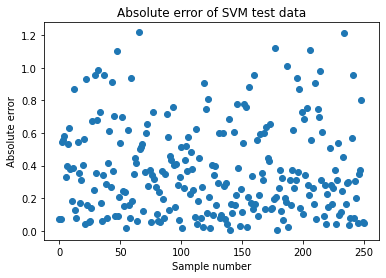

In [ ]:
# plotting the residuals - otherwise known as absolute error
residuals_abs = np.absolute(np.array(results) - np.array(ymid))
pplt.scatter(np.arange(len(residuals_abs)), residuals_abs)
pplt.xlabel("Sample number")
pplt.ylabel("Absolute error")
pplt.title("Absolute error of test data")

Text(0, 0.5, 'count')

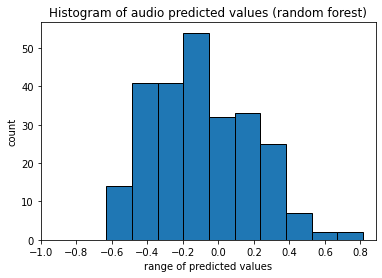

In [ ]:
# We also plot the distribution of predicted values. Offset is used to compare
# how the model otherwise would have looked if prediction results were to be
# nudged by a constant.

offset = 0.25
offsetresults = [r+offset for r in results]

pplt.hist(offsetresults, bins=10, edgecolor = "black")
pplt.title("Histogram of audio predicted values (random forest)")
pplt.xticks(np.arange(-1, 1, 0.2))
pplt.xlabel("range of predicted values")
pplt.ylabel("count")

In [ ]:
# count how many datapoints are negative and positive
neg = 0
pos = 0
for result in offsetresults:
  if(result<0):
    neg += 1
  else:
    pos += 1

print(neg, pos)

161 90


Text(0, 0.5, 'count')

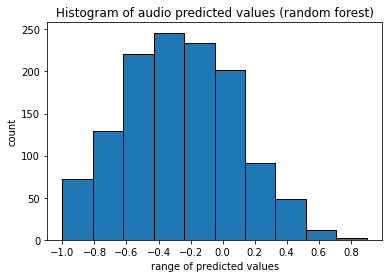

In [ ]:
# also check the histogram distribution of the data
fullframe = pd.read_csv("/content/testgroundtruth/annotate_with_means.csv", header=None)
annovalues = fullframe[fullframe.columns[np.r_[1]]].values.reshape(1, -1)[0]

pplt.hist(annovalues, bins=10, edgecolor = "black")
pplt.title("Histogram of known audio values (random forest)")
pplt.xticks(np.arange(-1, 1, 0.2))
pplt.xlabel("range of predicted values")
pplt.ylabel("count")